# Exploration of geographical biases in NER algorithms

This notebook is made to explore possible geographical biases in NER algorithms. 

Just like the exploration made on first names, we are testing the four NER models available in Spacy 3.1.

Those models will be tested on two different things:
- country names
- city names

The same kind of procedure is used here. 

The main difference comes from the fact there does not exist a kind of winogender schema for geographical named entity. 
Therefore, we need to construct the sentences ourselves, by:

- Selecting a good number of city/country names from different parts of the world. 
- Getting the wikipedia summary of those cities/countries
- Selecting the sentences containing the city/country names. 
- Replacing the city and country names respectively by `$CITY` and `$COUNTRY`.

This procedure allows us to apply the model on real sentences. 

The rest of the notebook is basically the same as the notebook of the exploration of the first names.

First, we will define some utility functions we will then be using for the countries and the cities. 

## Importing the packages

In [1]:
import geopandas as gpd

C:\Users\adrie\Anaconda3\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [86]:
import wikipedia
import pandas as pd

import re
from tqdm import tqdm

In [62]:
import spacy 

C:\Users\adrie\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\adrie\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\adrie\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\adrie\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

## Utils

In [63]:
nlp_sm = spacy.load("en_core_web_sm")
nlp_md = spacy.load("en_core_web_md")
nlp_lg = spacy.load("en_core_web_lg")
nlp_trf = spacy.load("en_core_web_trf")

In [89]:
def predict_NER_spacy(text, model):
    """
    model: str 
        either:
            'sm'
            'md'
            'lg'
            'trf'
    """
    if model=='sm':
        doc=nlp_sm(text)
    elif model=='md':
        doc=nlp_md(text)
    elif model=='lg':
        doc=nlp_lg(text)
    elif model=='trf':
        doc=nlp_trf(text)
    else:
        return np.nan
        
    predicted_label_liste=[str(ent).strip() for ent in doc.ents]
    return predicted_label_liste

#Is the name found ?? 
def check_names_prediction_country(row):
    var_0=0
    if row['name'] in row['spacy_prediction']:
        var_0 = 1
    return var_0

In [88]:
def compute_stats_names(df_test_company, model):
    """
    Model is a str of the name of the model
    
    """
    #Creating a new dataframe:
    df_temp=pd.DataFrame()
    df_temp['score_'+model] = pd.concat([df_test_company['found']])
    df_temp['name'] = pd.concat([df_test_company['name']])
    #We then have one 'mean' score per name:
    df_temp = df_temp.groupby('name').agg({'score_'+model:'mean'}).reset_index(drop=False)
    return df_temp

In [90]:
def main_companies(df_test_country):

    #We define the df of the results:
    df_results=pd.DataFrame(data={'name':df_test_country['name'].unique()})
    #Then, we apply the models:
    for model in ['sm', 'md', 'lg', 'trf']:
        
        print('Testing the model: '+model)
        
        tqdm.pandas()
        df_test_country['spacy_prediction'] = df_test_country['sentence'].progress_apply(lambda x: predict_NER_spacy(x, model))
        #We replace the list with a string, because otherwise for a list like : [Emily if Camila], neither Emily or Camila 
        #Would be mark as 1 by the test above. 
        df_test_country['spacy_prediction'] = df_test_country['spacy_prediction'].apply(lambda l : ' '.join(l))
        #We apply the function to check if the names were understood as NER by the model: 
        df_test_country['found'] = df_test_country.apply(check_names_prediction_country, axis=1)
        
        
        #computing the stats:
        #And merging with the results df:
        df_results = df_results.merge(compute_stats_names(df_test_country, model), left_on='name', right_on='name', how='right')
    return df_results

## City names

## Countries

We are using the world dataframe available with geopandas

In [68]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [69]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [70]:
world.isna().sum()

pop_est       0
continent     0
name          0
iso_a3        0
gdp_md_est    0
geometry      0
dtype: int64

In [71]:
world.shape

(177, 6)

### Sentence templates

We are using the wikipedia API to retrieve the sentences inside the summary of the wikipedia pages of the country containing the name of this country. 

Then, for each sentence we replace the name of the country by '$COUNTRY', in order to use those sentences as templates in an other part. 

In [72]:
list_sentences=[]
list_countries=[]
for country in world['name'].unique():
    try:
        #We are adding country to avoid any mistakes and to find more countries.
        summary = wikipedia.summary(country + ' country')
        for sentence in summary.split('. '):
            if country.lower() in sentence.lower():
                list_sentences.append(sentence)
                list_countries.append(country)
    except:
        print('not found : ', country)
        
#Constructing the dataframe:
df_sentences_template_country = pd.DataFrame(data = {'sentences':list_sentences, 'name':list_countries})

not found :  Dem. Rep. Congo
not found :  Dominican Rep.
not found :  Falkland Is.
not found :  Timor-Leste
not found :  Côte d'Ivoire
not found :  Guinea-Bissau
not found :  Central African Rep.


C:\Users\adrie\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\adrie\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


not found :  Congo
not found :  Eq. Guinea
not found :  Czechia
not found :  Bosnia and Herz.


Almost all of the countries were found, before cleaning the sentences, let's have a look at them:

In [73]:
df_sentences_template_country

,sentences,name
0,"Fiji ( (listen) FEE-jee; Fijian: Viti, [ˈβitʃi...",Fiji
1,Fiji consists of an archipelago of more than 3...,Fiji
2,About three-quarters of Fijians live on Viti L...,Fiji
3,The interior of Viti Levu is sparsely inhabite...,Fiji
4,The geothermal systems on Viti Levu are non-vo...,Fiji
...,...,...
1618,"Trinidad and Tobago ( (listen), ), officially ...",Trinidad and Tobago
1619,Consisting of the main islands Trinidad and To...,Trinidad and Tobago
1620,Trinidad and Tobago were ceded to Britain in 1...,Trinidad and Tobago
1621,Trinidad and Tobago obtained independence in 1...,Trinidad and Tobago


1623 sentences were found, and some seem quite odd - especially the first ones. 

For the sake of simplicity, we are only taking the 2 last ones. 

In [74]:
df_sentences_template_country = df_sentences_template_country.groupby('name').agg({'sentences':'last'}).reset_index()

Now we can clean the sentences:

In [75]:
def clean_template(row):
    """
    function clean_template applied to each row in order to replace the company names in the sentences by '$COMPANY'
    to use them after in the construction of the sentences. 
    """
    #Check for company names in the sentence, ignoring the case:
    sent = row['sentences']
    while re.search(row['name'], sent, re.IGNORECASE):
        match = re.search(row['name'], sent, re.IGNORECASE)
        sent = sent[:match.span()[0]] + '$COUNTRY' + sent[match.span()[1]:]
        return sent

In [76]:
df_sentences_template_country['clean_sentence'] = df_sentences_template_country.apply(clean_template, axis=1)

In [77]:
df_sentences_template_country.sample(1)['clean_sentence'].values

array(['$COUNTRY has a newly industrialised market economy, ranked third-largest in Southeast Asia and 33rd-largest in the world'],
      dtype=object)

We save the template

In [78]:
df_sentences_template_country.to_csv('Data/template_country.csv', index=False)

### Constructing the sentences

In [79]:
print('We have {} sentences'.format(df_sentences_template_country.shape[0]))
print('and {} country names'.format(world.shape[0]))
print('This gives {} possible sentences.'.format(df_sentences_template_country.shape[0] * world.shape[0]))

We have 159 sentences
and 177 country names
This gives 28143 possible sentences.


Then, we can compute all the sentences - every country names and every sentences. 

In [83]:
list_sentences_modified=[]
list_countries=[]
for country in world['name'].unique():
    for sentence in df_sentences_template_country['clean_sentence'].unique():
        list_sentences_modified.append(sentence.replace('$COUNTRY', country))
        list_countries.append(country)
df_country_test = pd.DataFrame(data={'sentence':list_sentences_modified, 'name':list_countries})

In [84]:
df_country_test

,sentence,name
0,"Fiji's economy is the world's 96th largest, wi...",Fiji
1,"Fiji is a member of the United Nations, World ...",Fiji
2,Fiji's military is one of the largest in Afric...,Fiji
3,Fijin culture reflects centuries of Portuguese...,Fiji
4,Seven sovereign states have made territorial c...,Fiji
...,...,...
28138,Contemporary issues in S. Sudan include corrup...,S. Sudan
28139,Another attempt to restore South S. Sudan as a...,S. Sudan
28140,"In 2010, the World Bank named S. Sudan one of ...",S. Sudan
28141,Emmerson Mnangagwa has since served as S. Suda...,S. Sudan


### Applying the model

In [91]:
df_results_country = main_companies(df_country_test)

  0%|                                                                              | 15/28143 [00:00<03:09, 148.45it/s]

Testing the model: sm


  0%|                                                                              | 12/28143 [00:00<04:06, 114.28it/s]

Testing the model: md


  0%|                                                                              | 12/28143 [00:00<04:06, 114.32it/s]

Testing the model: lg


  0%|                                                                                | 2/28143 [00:00<29:04, 16.13it/s]

Testing the model: trf


100%|████████████████████████████████████████████████████████████████████████████| 28143/28143 [39:29<00:00, 11.87it/s]


In [92]:
df_results_country.to_csv('Data/results/results_country.csv', index=False)

In [94]:
#Computing the average score:
df_results_country['avg_score']=df_results_country[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

In [103]:
df_results_country_merge = world.merge(df_results_country, left_on='name', right_on='name', how='right')

### Results

#### Map by country

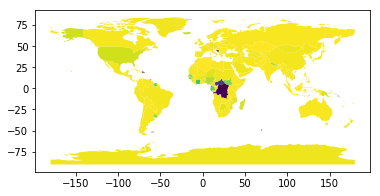

In [105]:
df_results_country_merge.plot('avg_score')

#### results by continent

In [108]:
df_results_country_merge.groupby('continent').mean()

,pop_est,gdp_md_est,score_sm,score_md,score_lg,score_trf,avg_score
continent,,,,,,,
Africa,2.390542e+07,1.181430e+05,0.840301,0.897521,0.909113,0.961648,0.902146
Antarctica,4.050000e+03,8.100000e+02,0.974843,0.968553,0.974843,0.974843,0.973270
Asia,9.338606e+07,1.179460e+06,0.936170,0.949686,0.958384,0.992908,0.959287
Europe,1.913842e+07,6.483302e+05,0.938720,0.956136,0.957426,0.986454,0.959684
North America,3.183567e+07,1.305841e+06,0.851502,0.874563,0.870720,0.945842,0.885657
Oceania,5.254692e+06,2.018407e+05,0.743935,0.841869,0.822102,0.975741,0.845912
Seven seas (open ocean),1.400000e+02,1.600000e+01,0.006289,0.000000,0.000000,0.937107,0.235849
South America,3.219544e+07,4.905455e+05,0.813256,0.904209,0.901790,0.990808,0.902516


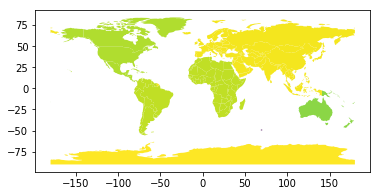

In [115]:
world.merge(df_results_country_merge.groupby('continent').mean().reset_index(drop=False), left_on='continent', right_on='continent', how='left').plot('avg_score')

#### Correlations with GDP and Population:

In [107]:
df_results_country_merge.corr()

,pop_est,gdp_md_est,score_sm,score_md,score_lg,score_trf,avg_score
pop_est,1.000000,0.800898,0.076205,0.057662,0.056331,0.026757,0.063994
gdp_md_est,0.800898,1.000000,0.094386,0.062700,0.062577,0.049508,0.076677
score_sm,0.076205,0.094386,1.000000,0.821181,0.829561,0.613558,0.920829
score_md,0.057662,0.062700,0.821181,1.000000,0.966654,0.703151,0.965493
score_lg,0.056331,0.062577,0.829561,0.966654,1.000000,0.726239,0.971123
score_trf,0.026757,0.049508,0.613558,0.703151,0.726239,1.000000,0.772331
avg_score,0.063994,0.076677,0.920829,0.965493,0.971123,0.772331,1.000000
